In [4]:
import Cnn_tool.cnn_ana_py

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch

In [6]:
# 試行回数
trial_number = 1

## CNNを用いた$\pi^{0}$と$\gamma$のclassification(0.15m, 100GeV)

### 入力するDataSetの読み込みと処理

In [9]:
#read Dataset
ds_gamma = np.load("./gamma_hitmap.npy")

ds_pi0 = np.load("./pi0_hitmap.npy")

In [10]:
# create label
# Backgraund = kaon, Signal = pi
b = np.full(10000, 0)
s = np.full(10000, 1)
event_number = np.arange(20000)
print(b, s, event_number)

[0 0 0 ... 0 0 0] [1 1 1 ... 1 1 1] [    0     1     2 ... 19997 19998 19999]


In [11]:
print(ds_gamma.shape, ds_pi0.shape)

(10000, 20, 20, 40) (10000, 20, 20, 40)


In [12]:
# create x_dataset
x = np.concatenate([ds_gamma, ds_pi0])
x = x[:, np.newaxis, :, :, :]

#y_datasetの作成
y = np.concatenate([b, s])

print(x.shape, y.shape)

(20000, 1, 20, 20, 40) (20000,)


In [13]:
# dataset split to train, valid and test
tv_t_seed = np.random.randint(1, 10000)
x_train_valid, x_test, y_train_valid, y_test, en_train_valid, en_test = train_test_split(x, y, event_number, train_size=0.8, random_state=tv_t_seed)

t_v_seed = np.random.randint(1, 10000)
x_train, x_valid, y_train, y_valid, en_train, en_train_valid = train_test_split(x_train_valid, y_train_valid, en_train_valid, train_size=0.75, random_state=t_v_seed)
print(x_train.shape, x_valid.shape, x_test.shape)

(12000, 1, 20, 20, 40) (4000, 1, 20, 20, 40) (4000, 1, 20, 20, 40)


### TorchTensol, DataLoaderへの変換

In [14]:
# import
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch import tensor, float32

In [15]:

train_c1 = TensorDataset(tensor(x_train, dtype=float32), tensor(y_train[:, np.newaxis], dtype=float32))
valid_c1 = TensorDataset(tensor(x_valid, dtype=float32), tensor(y_valid[:, np.newaxis], dtype=float32))
test_c1 = TensorDataset(tensor(x_test, dtype=float32), tensor(y_test[:, np.newaxis], dtype=float32))

In [16]:
#DataLoader
batch_size = 128
train_c1_dataloader = DataLoader(train_c1, batch_size=batch_size, shuffle=True)
valid_c1_dataloader = DataLoader(valid_c1, batch_size=batch_size, shuffle=True)
test_c1_dataloader = DataLoader(test_c1, batch_size=batch_size, shuffle=False)

### modelの定義

In [17]:
import torch.nn as nn
from torch.nn import Sequential, Flatten, Conv3d, MaxPool3d, Linear, ReLU, Sigmoid

class ConvNet(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.conv_relu_stack = Sequential(
            Conv3d(input_shape, 64, 3), # output_channels=64, karnel_size=3
            Conv3d(64, 64, 3), # input_channels=64, output_channels=64, karnel_size=3
            MaxPool3d(2, 2), # karnel_size=2, stride=2
            ReLU(),
            Conv3d(64, 32, 3), # input_channels=64, output_channels=32, karnel_size=3
            Conv3d(32, 32, 3), # input_channels=32, output_channels=32, karnel_size=3
            MaxPool3d(2, 2), # karnel_size=2, stride=2
            ReLU()
        ) # input:W=H=20 D=40, C output:W=H=2 D=7, C=32
        self.linear_relu_stack = Sequential(
            Flatten(),
            Linear(32*2*2*7, 128), #input=32*2*2*7, output=128
            ReLU(),
            Linear(128, 1), #input=128, output=1
            Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.linear_relu_stack(x)
        return x

In [18]:
#trainingの時とtestの時にmodelを動かすための関数

def train(dataloader, model, loss_fn, optimizer):
    # modelをtrain modelに切り替える
    model.train()
    # 1 epochでのlossの合計を入力する変数
    train_loss_total = 0.
    for x, y in dataloader:
        x, y = x.to("cuda"), y.to("cuda")
        # 順伝播
        y_pred = model(x)
        # loss function
        loss = loss_fn(y_pred, y)
        train_loss_total += loss
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # loss average
    train_loss = train_loss_total/len(dataloader)
    return train_loss

def valid(dataloader, model, loss_fn, threshold=0.5):
    # modelをevaluation modeに切り替える
    model.eval()
    # 1 epochでのlossの合計を入力する変数
    valid_loss_total = 0.
    # anserとyが一致した回数を入力する変数
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to("cuda"), y.to("cuda")
            # 順伝播
            y_pred = model(x)
            # loss function
            loss = loss_fn(y_pred, y)
            valid_loss_total += loss
            # accuracyを計算するためのthreshold
            np_threshold = np.full(y.shape[0],threshold)
            tensor_threshold = tensor(np_threshold[:, np.newaxis], dtype=float32).to("cuda")
            # anserとyが一致した回数
            anser = (y_pred>=tensor_threshold).type(float32)
            correct += (anser==y).type(float32).sum().item()
    # loss average
    valid_loss = valid_loss_total/len(dataloader)
    # accuracy
    correct /= len(dataloader.dataset)
    return valid_loss, correct

In [19]:
def test(dataloader, model):
    # modelをevaluation modeに切り替える
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to("cuda"), y.to("cuda")
            # 順伝播
            y_pred = model(x)
            # print(y_pred.size(), y.size())
            np_y_pred = y_pred.to("cpu").detach().numpy()
            np_y = y.to("cpu").detach().numpy()
            if i==0:
                output = np_y_pred
                true = np_y
            else:
                output = np.concatenate([output, np_y_pred], axis=0)
                true = np.concatenate([true, np_y], axis=0)
    # output = np.array(output)
    # true = np.array(true)
    return output, true

### 学習

### input channel = 1

In [20]:
# loss_function = BCEloss, optimizer = Adam
from torch.nn import BCELoss
from torch.optim import Adam

# model instance
# input_shape:batch_size=64, channels=1, W=H=100
model = ConvNet(1).to("cuda")

loss_fn = BCELoss()
optimizer = Adam(model.parameters())
# epochごとのlossを入力するリスト
tloss = []
vloss = []
# epochごとのaccuracyを入力するリスト
taccuracy = []
vaccuracy = []

# training
num_epoch = 10
for i_epoch in range(num_epoch):
    #train
    train_loss = train(train_c1_dataloader, model, loss_fn, optimizer)
    _, train_accuracy = valid(train_c1_dataloader, model, loss_fn) 
    tloss.append(train_loss.to("cpu").detach().numpy())
    taccuracy.append(train_accuracy)
    #validation
    valid_loss, valid_accuracy = valid(valid_c1_dataloader, model, loss_fn)
    vloss.append(valid_loss.to("cpu").detach().numpy())
    vaccuracy.append(valid_accuracy)

    print(f"Train loss: {train_loss:.5f}, Train accuraxy: {train_accuracy:.5f}, Validation loss: {valid_loss:.5f}, Validation accuracy: {valid_accuracy:.5f}")

tloss = np.array(tloss)
taccuracy = np.array(taccuracy)
vloss = np.array(vloss)
vaccuracy = np.array(vaccuracy)

Train loss: 0.70467, Train accuraxy: 0.58758, Validation loss: 0.67353, Validation accuracy: 0.56200
Train loss: 0.66603, Train accuraxy: 0.58925, Validation loss: 0.67361, Validation accuracy: 0.56600
Train loss: 0.65964, Train accuraxy: 0.60608, Validation loss: 0.66053, Validation accuracy: 0.59450
Train loss: 0.65544, Train accuraxy: 0.61333, Validation loss: 0.66148, Validation accuracy: 0.59600
Train loss: 0.65408, Train accuraxy: 0.61492, Validation loss: 0.65771, Validation accuracy: 0.59450
Train loss: 0.64942, Train accuraxy: 0.63433, Validation loss: 0.64421, Validation accuracy: 0.61950
Train loss: 0.58680, Train accuraxy: 0.75400, Validation loss: 0.51534, Validation accuracy: 0.73875
Train loss: 0.50980, Train accuraxy: 0.77050, Validation loss: 0.49380, Validation accuracy: 0.75425
Train loss: 0.46338, Train accuraxy: 0.78975, Validation loss: 0.47787, Validation accuracy: 0.76375
Train loss: 0.44453, Train accuraxy: 0.80650, Validation loss: 0.45879, Validation accuracy

評価

In [21]:
#　パラメータの保存
torch.save(model.state_dict(), f"./CNNparameter/Conv3Ds{trial_number}")

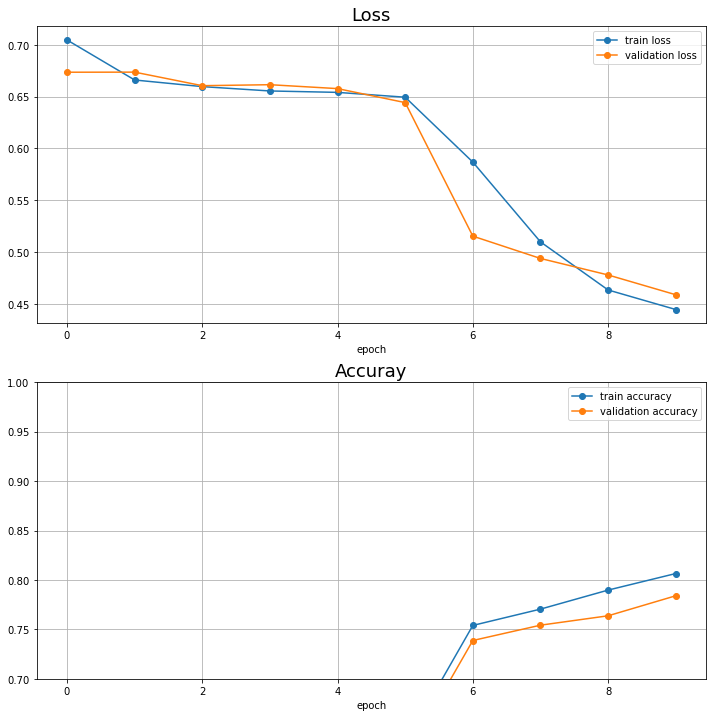

In [22]:
Cnn_tool.plot_loss_accuracy(tloss, vloss, taccuracy, vaccuracy)

In [23]:
np.save(f"./Conv3Ds_result/tloss{trial_number}", tloss)
np.save(f"./Conv3Ds_result/vloss{trial_number}", vloss)
np.save(f"./Conv3Ds_result/taccuracy{trial_number}", taccuracy)
np.save(f"./Conv3Ds_result/vaccuracy{trial_number}", vaccuracy)

In [24]:
output_y, true_y = test(test_c1_dataloader, model)
output_y = output_y.reshape([4000])
true_y = true_y.reshape([4000])
print(output_y.shape, type(output_y))
print(true_y.shape, type(true_y))
output_y
print(Cnn_tool.test_accuracy(output_y, true_y))

(4000,) <class 'numpy.ndarray'>
(4000,) <class 'numpy.ndarray'>
0.78175


(2, 4000)
(2, 2012) (2, 1988)


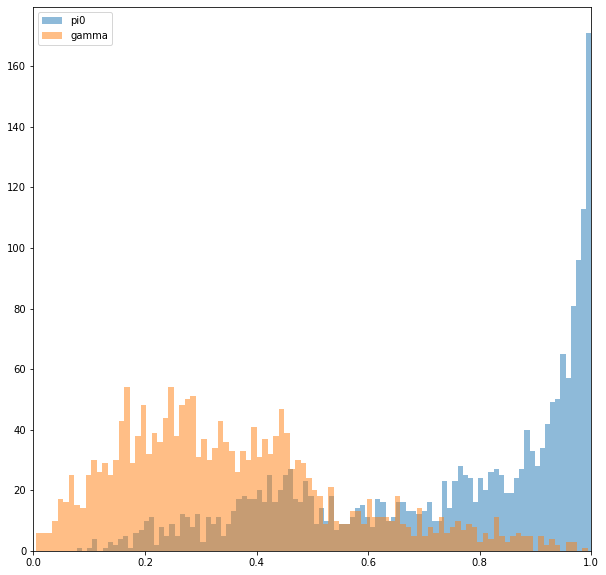

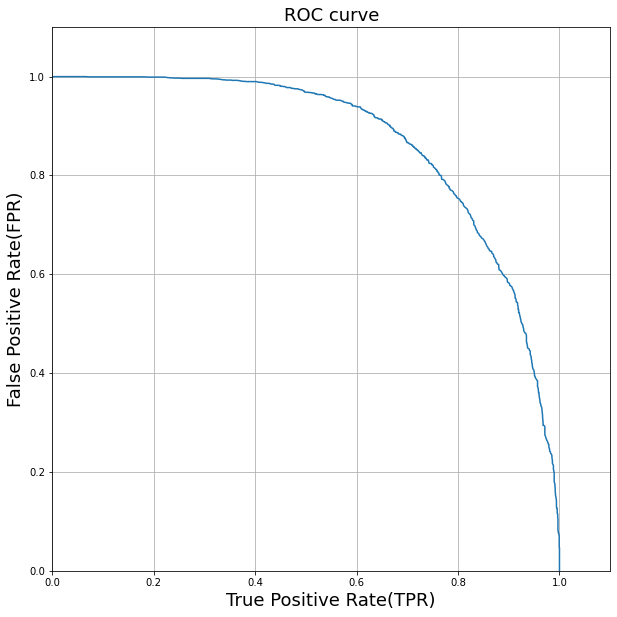

In [25]:
Cnn_tool.sb_histgram(output_y, true_y)
Cnn_tool.plot_roc(output_y, true_y)

In [26]:
x_test.shape
np.save(f"./Conv3Ds_result/x{trial_number}", x_test)
np.save(f"./Conv3Ds_result/y_output{trial_number}", output_y)
np.save(f"./Conv3Ds_result/y_label{trial_number}", true_y)
np.save(f"./Conv3Ds_result/y_label{trial_number}", en_test)